# Frequency modulated continuous wave (FMCW) radar

# 1. Introduction
Frequency modulated continuous wave (FMCW) radar is a radar which transmits and receives a continous sequecny of chirps.  Since it continously transmits and receives (as opposed to sending pulses) we call this type of radar continous wave (CW) as opposed to pulsed radar.  

FMCW radars have the following advantages:
- Allow us to measure distance to an object (range)
- Allow us to measure velocity of an object (doppler frequency)  

FMCW radars have the following disadvantages:
- Low max range compared to pulsed radar
- More complicated electronics
- more suseptible to RFI

FMCW radars are **always** implemented to perform stretch processing (matched filtering in hardware as opposed to digital).  

Recall from the pulse compression notebook that the output of the matched filter in hardware is:
$$y(t) = e^{j\left( - 2\pi f_0\tau_{rx} - 2\pi \gamma t\tau_{rx} + \pi \gamma \tau_{rx}^2 \right)}$$  
Each component can be classified as follows:

| term    | meaning | notes |
| -------- | ------- | ------- | 
| $- 2\pi \gamma t\tau_{rx}$  | Range term    | We use this to determine distacne to target |
| $- 2\pi f_0\tau_{rx}$ | Doppler term     | We use this to estimate the speed of a target over multiple pulses |
| $\pi \gamma \tau_{rx}^2$    | Residual video phase (RVP)  | This is sometimes referred to as a skew term.  Removal of this term is referred to as "deskewing"|  

For the scope of that discussion we only focused on the range term and neglected the doppler term.  Here we will investigate that in more depth.  

## FMCW Waveform
Since the FMCW waveform is continuously ramping we no longer have a notion of "pulses" per say.  The FMCW waveform continously transmits a chirp and continously receives chirps

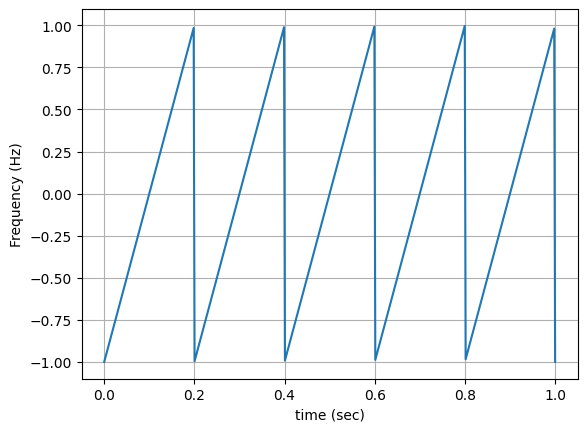

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
t = np.linspace(0, 1, 500)
plt.figure()
plt.plot(t, signal.sawtooth(2 * np.pi * 5 * t))
plt.xlabel('time (sec)')
plt.ylabel('Frequency (Hz)')
plt.grid()
plt.show()

# 2. Range estimation 
There is no special sauce for estimating range.  We already covered this in the pulse compression notebook!  But recall that our range is encoded as a beat frequency on our received signal.  If we want to determine the distance to our object we just take a FFT of the signal

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light
BW = 150e6  # bandwidth
fc = 77e9  # carrier frequency
n_adc = 256  # number of adc samples
n_chirp = 1 # Number of chirps per "image"
T = 10e-6  # PRI 
PRF = 1/T
f_s = n_adc/T  # sampling frequency
dt = 1/f_s  # sampling interval
chirp_rate = BW/T
wavelen = speed_of_light/fc
fast_time = dt * np.arange(0, n_adc)
slow_time = T * np.arange(n_chirp)
n_transmitters = 1
n_receivers = 1
max_velocity = wavelen/(T*4)  # Max unambiguous velocity m/s
range_resolution = speed_of_light/(2*BW)
max_range = f_s*speed_of_light/(2*chirp_rate) 
d_rx = wavelen/2  # distance between receivers
d_tx = 4*d_rx  # distance between transmitters

# Range, velocity, and angle axes
R = range_resolution * np.arange(fast_time.size)
V = np.linspace(-max_velocity, max_velocity, n_chirp)  # Velocity axis
ang_ax = np.arange(-90, 90, 1)  # angle axis



In [3]:
# Setup the antennas
tx_loc = np.zeros((n_transmitters, 3))
tx_loc[:, 0] = d_tx * np.arange(n_transmitters)

rx_loc = np.zeros((n_receivers, 3))
rx_loc[:, 0] = tx_loc[-1][0] + d_tx + d_rx * np.arange(n_receivers)


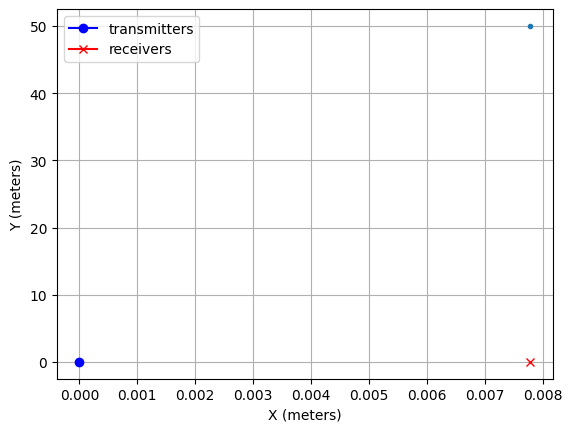

In [4]:
# set up targets
def create_target(pos, vel):
    _pos = np.zeros(3)
    _vel = np.zeros(3)
    _pos[0] = pos[0]
    _pos[1] = pos[1]

    _vel[0] = vel[0]
    _vel[1] = vel[1]
    return _pos + _vel[None, :] * slow_time[:, None]

targets = [
    create_target(
        pos=(rx_loc[0, 0], 50),
        # vel=(5, pos)
        vel=(0, 0)
    )
]


plt.figure()
plt.plot(tx_loc[:, 0], tx_loc[:, 1], color='b', marker='o', label='transmitters')
plt.plot(rx_loc[:, 0], rx_loc[:, 1], color='r', marker='x', label='receivers')
for tgt in targets:
    plt.plot(tgt[:, 0], tgt[:, 1], '.')
plt.legend()
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.grid()

In [5]:
# compute delays to targets
delays = np.zeros((n_transmitters, n_receivers, len(targets), slow_time.size))
distances = np.zeros((n_transmitters, n_receivers, len(targets), slow_time.size))
for i, tx_pos in enumerate(tx_loc):
    for j, rx_pos in enumerate(rx_loc):
        for k, tgt in enumerate(targets):
            tx_to_target = np.linalg.norm(tgt - tx_pos, axis=-1)
            rx_to_target = np.linalg.norm(tgt - rx_pos, axis=-1)
            distances[i, j, k, :] = (tx_to_target + rx_to_target)  # just for debugging 
            delays[i, j, k, :] = distances[i, j, k, :] / (speed_of_light)
print(delays.shape)
# compute returned signal
sig = np.zeros((n_transmitters, n_receivers, fast_time.size, slow_time.size), dtype=np.complex128)
def received_signal(t, delay):
    # return np.exp(1.0j * (-2*np.pi * fc * delay - 2 * np.pi * chirp_rate * delay * t + np.pi *chirp_rate * delay**2))
    return np.exp(1.0j * (-2*np.pi * fc * delay - 2 * np.pi * chirp_rate * delay * t))

for i_tx in range(n_transmitters):
    for i_rx in range(n_receivers):
        for i_chirp in range(n_chirp):
            for i_tgt in range(len(targets)):
                sig[i_tx, i_rx, :, i_chirp] += received_signal(fast_time, delays[i_tx, i_rx, i_tgt, i_chirp])


(1, 1, 1, 1)


(256,)


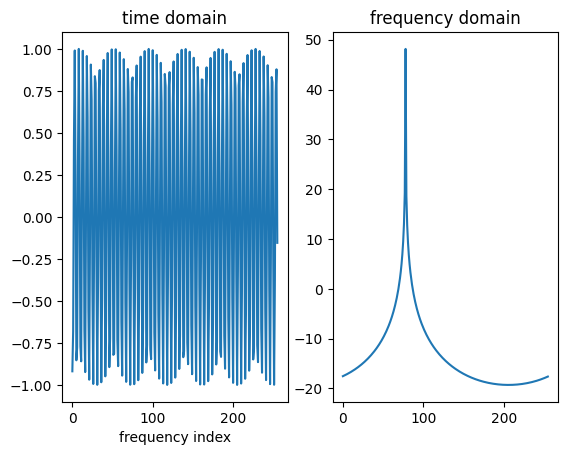

In [6]:
ref = sig[0, 0, :, 0]
print(ref.shape)
range_fft = np.fft.fft(ref, axis=0)

def db(x):
    return 20 * np.log10(np.abs(x))

fig, axs = plt.subplots(ncols=2)
axs = axs.flatten()
axs[0].plot(np.real(ref))
axs[0].set_title('time domain')
axs[0].set_xlabel('time index')
axs[1].plot(db(np.fft.fftshift(range_fft, axes=0)))
axs[1].set_title('frequency domain')
axs[0].set_xlabel('frequency index')
plt.show()


# 3. Velocity Estimation
To estimate a signals velocity we explore how the doppler term $- 2\pi f_0\tau_{rx}$ changes from chirp to chirp.  To estimate an object's velocity we will create a block of data by stacking $N$ chirps into an array then seeing how that phase term varies from chirp to chirp 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light
BW = 150e6  # bandwidth
fc = 77e9  # carrier frequency
n_adc = 256  # number of adc samples
n_chirp = 256 # Number of chirps per "image"
T = 10e-6  # PRI 
PRF = 1/T
f_s = n_adc/T  # sampling frequency
dt = 1/f_s  # sampling interval
chirp_rate = BW/T
wavelen = speed_of_light/fc
fast_time = dt * np.arange(0, n_adc)
slow_time = T * np.arange(n_chirp)
n_transmitters = 1
n_receivers = 1
max_velocity = wavelen/(T*4)  # Max unambiguous velocity m/s
range_resolution = speed_of_light/(2*BW)
max_range = f_s*speed_of_light/(2*chirp_rate) 
d_rx = wavelen/2  # distance between receivers
d_tx = 4*d_rx  # distance between transmitters

# Range, velocity, and angle axes
R = range_resolution * np.arange(fast_time.size)
V = np.linspace(-max_velocity, max_velocity, n_chirp)  # Velocity axis
ang_ax = np.arange(-90, 90, 1)  # angle axis

# Setup the antennas
tx_loc = np.zeros((n_transmitters, 3))
tx_loc[:, 0] = d_tx * np.arange(n_transmitters)

rx_loc = np.zeros((n_receivers, 3))
rx_loc[:, 0] = tx_loc[-1][0] + d_tx + d_rx * np.arange(n_receivers)

# set up targets
def create_target(pos, vel):
    _pos = np.zeros(3)
    _vel = np.zeros(3)
    _pos[0] = pos[0]
    _pos[1] = pos[1]

    _vel[0] = vel[0]
    _vel[1] = vel[1]
    return _pos + _vel[None, :] * slow_time[:, None]

targets = [
    create_target(
        pos=(rx_loc[0, 0], 50),
        vel=(0, 10)
    ),
    create_target(
        pos=(rx_loc[0, 0], 50),
        vel=(0, -10)
    )
]

# compute delays to targets
delays = np.zeros((n_transmitters, n_receivers, len(targets), slow_time.size))
distances = np.zeros((n_transmitters, n_receivers, len(targets), slow_time.size))
for i, tx_pos in enumerate(tx_loc):
    for j, rx_pos in enumerate(rx_loc):
        for k, tgt in enumerate(targets):
            tx_to_target = np.linalg.norm(tgt - tx_pos, axis=-1)
            rx_to_target = np.linalg.norm(tgt - rx_pos, axis=-1)
            distances[i, j, k, :] = (tx_to_target + rx_to_target)  # just for debugging 
            delays[i, j, k, :] = distances[i, j, k, :] / (speed_of_light)

# compute returned signal
sig = np.zeros((n_transmitters, n_receivers, fast_time.size, slow_time.size), dtype=np.complex128)
def received_signal(t, delay):
    # return np.exp(1.0j * (-2*np.pi * fc * delay - 2 * np.pi * chirp_rate * delay * t + np.pi *chirp_rate * delay**2))
    return np.exp(1.0j * (-2*np.pi * fc * delay - 2 * np.pi * chirp_rate * delay * t))

for i_tx in range(n_transmitters):
    for i_rx in range(n_receivers):
        for i_chirp in range(n_chirp):
            for i_tgt in range(len(targets)):
                sig[i_tx, i_rx, :, i_chirp] += received_signal(fast_time, delays[i_tx, i_rx, i_tgt, i_chirp])



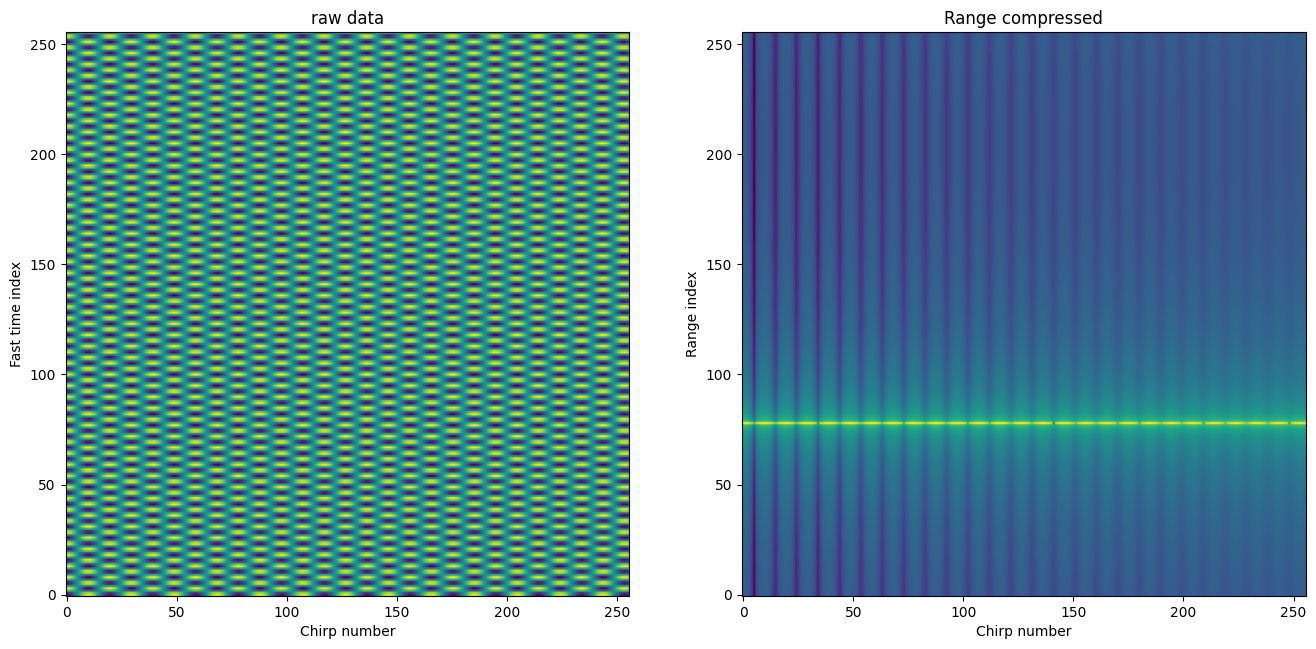

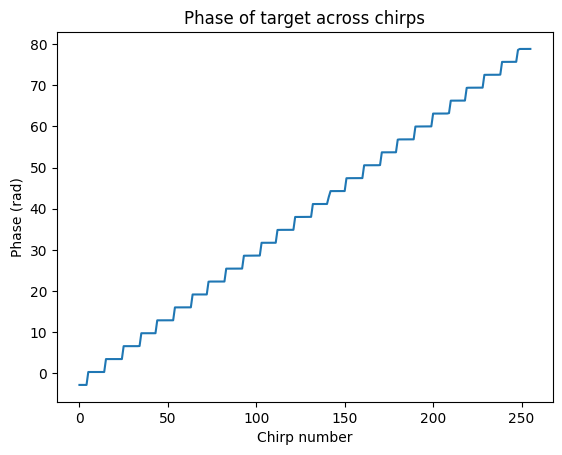

In [11]:
ref = sig[0, 0, :, :]
range_fft = np.fft.fft(ref, axis=0)
range_fft = np.fft.fftshift(range_fft, axes=0)

def db(x):
    return 20 * np.log10(np.abs(x))

fig, axs = plt.subplots(ncols=2, figsize=(16, 16))
axs = axs.flatten()

axs[0].imshow(np.real(ref), origin='lower')
axs[0].set_xlabel('Chirp number')
axs[0].set_ylabel('Fast time index')
axs[0].set_title('raw data')

axs[1].imshow(db(range_fft), origin='lower')
axs[1].set_xlabel('Chirp number')
axs[1].set_ylabel('Range index')
axs[1].set_title('Range compressed')

r, c = np.unravel_index(
    np.argmax(np.abs(range_fft).flatten()),
    range_fft.shape
)
dp_cut = range_fft[r, :]
plt.figure()
plt.plot(np.unwrap(np.angle(dp_cut)))
plt.xlabel('Chirp number')
plt.ylabel('Phase (rad)')
plt.title('Phase of target across chirps')
plt.show()


Recall that the definition of frequency is defined as the derivate of phase over time:
$$f = \frac{d\phi}{dt}$$  

Looking at this we see that the target's doppler frequency will be encoded as a linear phase over time which means when we can take a fourier transform of over chirps to get a spike where the doppler of the target was

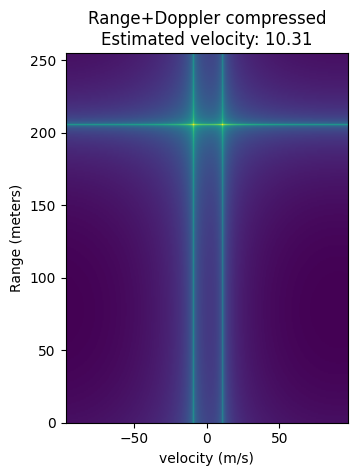

In [12]:
doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, axis=1))
r, c = np.unravel_index(
    np.argmax(np.abs(doppler_fft).flatten()),
    range_fft.shape
)
estimated_velocity = V[c]
fig, axs = plt.subplots()
axs.imshow(
    db(doppler_fft),
    extent=[V.min(), V.max(), R.min(), R.max()],
    origin='lower',
)
axs.set_xlabel('velocity (m/s)')
axs.set_ylabel('Range (meters)')
axs.set_title(f'Range+Doppler compressed\nEstimated velocity: {estimated_velocity:.2f}')
plt.show()


The image of range and doppler over a fixed number of chirps is known as the range doppler map. Notice that this does not spatially resolve our targets; it just tells us how far away things were and how fast they were going. 

# 4. Range-Angle map
Most FMCW systems are multiple input multiple output (MIMO) systems because they have multiple transmit chains and multiple receive chains.  Let's examine what happens when we use an antenna array with the simulation

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light
BW = 150e6  # bandwidth
fc = 77e9  # carrier frequency
n_adc = 256  # number of adc samples
n_chirp = 512 # Number of chirps per "image"
T = 10e-6  # PRI 
PRF = 1/T
f_s = n_adc/T  # sampling frequency
dt = 1/f_s  # sampling interval
chirp_rate = BW/T
wavelen = speed_of_light/fc
fast_time = dt * np.arange(0, n_adc)
slow_time = T * np.arange(n_chirp)
n_transmitters = 1
n_receivers = 256
max_velocity = wavelen/(T*4)  # Max unambiguous velocity m/s
range_resolution = speed_of_light/(2*BW)
max_range = f_s*speed_of_light/(2*chirp_rate) 
d_rx = wavelen/2  # distance between receivers
d_tx = 4*d_rx  # distance between transmitters

# Range, velocity, and angle axes
R = range_resolution * np.arange(fast_time.size)
V = np.linspace(-max_velocity, max_velocity, n_chirp)  # Velocity axis
ang_ax = np.arange(-90, 90, 1)  # angle axis



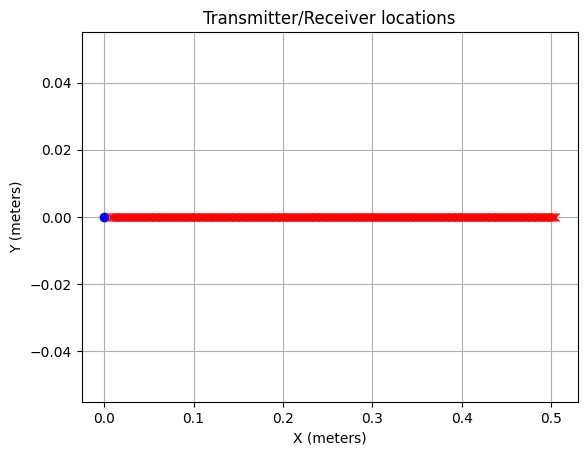

In [44]:
# Setup the antennas
tx_loc = np.zeros((n_transmitters, 3))
tx_loc[:, 0] = d_tx * np.arange(n_transmitters)

rx_loc = np.zeros((n_receivers, 3))
rx_loc[:, 0] = tx_loc[-1][0] + d_tx + d_rx * np.arange(n_receivers)

plt.figure()
plt.plot(tx_loc[:, 0], tx_loc[:, 1], 'bo')
plt.plot(rx_loc[:, 0], rx_loc[:, 1], 'rx')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.grid()
plt.title('Transmitter/Receiver locations')
plt.show()


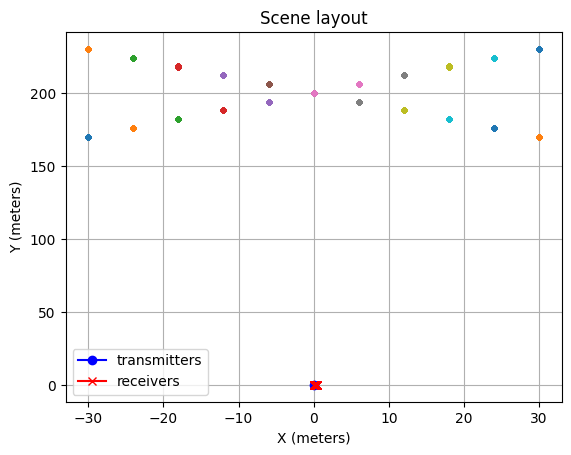

In [51]:
# set up targets
def create_target(pos, vel):
    _pos = np.zeros(3)
    _vel = np.zeros(3)
    _pos[0] = pos[0]
    _pos[1] = pos[1]

    _vel[0] = vel[0]
    _vel[1] = vel[1]
    return _pos + _vel[None, :] * slow_time[:, None]

# A cool layout
targets = [
    create_target(
        pos=(pos, 200 + pos),
        vel=(0, 10)
    )
    for pos in np.linspace(-30, 30, 11)
    
] + [
    create_target(
        pos=(pos, 200 - pos),
        vel=(0, 10)
    )
    for pos in np.linspace(-30, 30, 11)
]
# targets = [
#     create_target(
#         pos=(-10, 200),
#         vel=(0, 10)
#     ),
#     create_target(
#         pos=(10, 200),
#         vel=(0, 10)
#     ),
#     create_target(
#         pos=(-10, 180),
#         vel=(0, 10)
#     ),
#     create_target(
#         pos=(10, 180),
#         vel=(0, 10)
#     ),
# ]

plt.figure()
plt.plot(tx_loc[:, 0], tx_loc[:, 1], color='b', marker='o', label='transmitters')
plt.plot(rx_loc[:, 0], rx_loc[:, 1], color='r', marker='x', label='receivers')
for tgt in targets:
    plt.plot(tgt[:, 0], tgt[:, 1], '.')
plt.legend()
plt.title('Scene layout')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.grid()
plt.show()

In [52]:
# compute delays to targets
delays = np.zeros((n_transmitters, n_receivers, len(targets), slow_time.size))
distances = np.zeros((n_transmitters, n_receivers, len(targets), slow_time.size))
for i, tx_pos in enumerate(tx_loc):
    for j, rx_pos in enumerate(rx_loc):
        for k, tgt in enumerate(targets):
            tx_to_target = np.linalg.norm(tgt - tx_pos, axis=-1)
            rx_to_target = np.linalg.norm(tgt - rx_pos, axis=-1)
            distances[i, j, k, :] = (tx_to_target + rx_to_target)  # just for debugging 
            delays[i, j, k, :] = distances[i, j, k, :] / (speed_of_light)
print(delays.shape)


(1, 256, 22, 512)


In [53]:
# compute returned signal
sig = np.zeros((n_transmitters, n_receivers, fast_time.size, slow_time.size), dtype=np.complex128)
def received_signal(t, delay):
    # return np.exp(1.0j * (-2*np.pi * fc * delay - 2 * np.pi * chirp_rate * delay * t + np.pi *chirp_rate * delay**2))
    return np.exp(1.0j * (-2*np.pi * fc * delay - 2 * np.pi * chirp_rate * delay * t))

for i_tx in range(n_transmitters):
    for i_rx in range(n_receivers):
        for i_chirp in range(n_chirp):
            for i_tgt in range(len(targets)):
                sig[i_tx, i_rx, :, i_chirp] += received_signal(fast_time, delays[i_tx, i_rx, i_tgt, i_chirp])

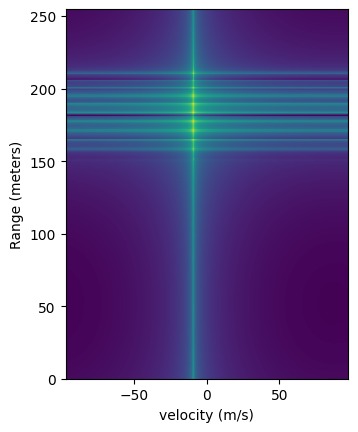

In [54]:
ref = sig[0, 0, :, :]
range_fft = np.fft.fft(ref, axis=0)

def db(x):
    return 20 * np.log10(np.abs(x))

doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, axis=1))
plt.figure()
plt.imshow(
    db(doppler_fft),
    extent=[V.min(), V.max(), R.min(), R.max()],
    origin='lower',
)
plt.ylabel('Range (meters)')
plt.xlabel('velocity (m/s)')
plt.show()

Here we see that we only have two distinct spikes in our image.  This is because the range-Doppler map doesnt give us any spatial information.  Let's see what happens if we estimate the angle of arrival of each point using the antenna array

(256, 256)


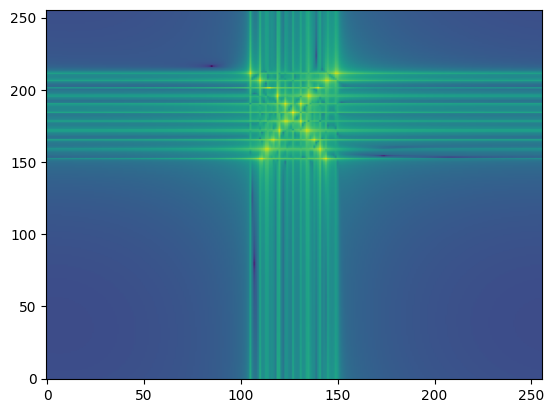

In [55]:
ref_ang = sig[0, :, :, 0].T
print(ref_ang.shape)
range_fft = np.fft.fftshift(np.fft.fft(ref_ang, axis=0), axes=0)
angle_fft = np.fft.fftshift(np.fft.fft(range_fft, axis=1), axes=1)
plt.figure()
plt.imshow(
    db(angle_fft[:, ::-1]),  # Reverse just for plotting purposes so azimuth lines up with our perspective 
    aspect='auto',
    origin='lower'
)
plt.show()

Here we see we have created an image of our scene by using the antenna array to determine the angle of arrival of each signal by looking at its angle spectrum.  Often times you will see people plot this image in the field of view of the radar:

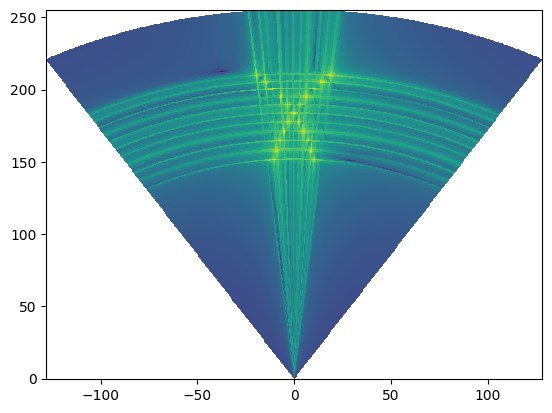

In [56]:
beamwidth = 2 / n_receivers

min_az_rad = np.deg2rad(-beamwidth/2)
max_az_rad = np.deg2rad(beamwidth/2)
# Create a grid of vertices that approximate the bounds of each
# radar cell (in polar coordinates).
A = np.linspace(-np.pi/6, np.pi/6, angle_fft.shape[1])
r, az = np.meshgrid(R, A)
# Convert polar to Cartesian coordinates.
grid_x = r * np.cos(az + np.pi/2)
grid_y = r * np.sin(az + np.pi/2)
plt.figure()
plt.pcolormesh(grid_x.T, grid_y.T, db(angle_fft))
plt.show()

We've shown how we can create an image using an antenna array, but the problem is to get an array response with narrow enough beamwidth we need a physically large array.  In our example we needed about 1 meter long array to get a "good" image out.  A 1 meter long array for a device that is probably the size of a wallet is not feasable.  

This is the driving motivation behind SAR!  Instead of physically building a large enough array to get a narrow beamwidth we synthesize a large unliform linear array by treating each location the sensor sends out a pulse as an element in an antenna array